In [2]:
# Import libraries to use 
import numpy as np
import matplotlib.pyplot as plt
import math       
import scipy as sp
import scipy.optimize
import subprocess # Library to run ngspice on shell
import seaborn as sns # Library to change the color palette for plots
import random
import timeit # To time computing time
import warnings # To supress warnings
import string

In [3]:
def readdata(filename,Labels,Data_points):
    out = subprocess.run(['ngspice', '-b', filename], 
                         stdout=subprocess.PIPE,  stderr=subprocess.PIPE)
    
    name = filename[:-4]+'.txt' # Name of the file to save output from ngspice
    
    # This saves output data in txt file
    with open(name, 'w') as output:
        for line in out.stdout.decode('ascii').split('\n'):
            output.write(line+'\n') # Writing output lines 
    
    # We get the data into an array 
    fill = np.zeros (len(Labels), dtype=int)
    
    f = open (name, 'r');
    src = []
    while True:  
        line = f.readline()
        if not line: break  # end of file
        if line[0] == '#':
            continue # treat next line
        src.append(line)

    #print(src)
    data = np.zeros ([Data_points, len(Labels)])

    for line in src:
        #print line
        # Here we initialize the ngspice data array
        '''
        if line.startswith('No.'):
            temp_list = line.split(":")
            Data_points = int(temp_list[-1])
            #print(Data_points)
            data = np.zeros ([Data_points, len(Labels)])
            #print(data.shape)
        '''
        
        
        # Here we determine the indexes for the current columns
        if line.startswith('Index'):
            temp_list = [str(x) for x in line.split()]
            #print(temp_list)
            n_columns = len (temp_list)
            index = np.zeros(n_columns, dtype = int)

            for j in range(n_columns):
                index [j] = Labels.index(temp_list[j])
            #print index

        # if the line starts with a number, we treat it as the data line
        if line[0].isdigit():
            temp_data = [float(x) for x in line.split()]

            for c in range(n_columns):
                r = fill[c]
                #print(r, index [c])

                data [r][index[c]] = temp_data [c]

                fill [c] = fill [c] + 1
                if fill [c] == Data_points:
                    fill [c] = 0
    return data

In [4]:
# Definition to generate netlist for an arbitraty number of sections

def generatingnetlist(filename,ns,Ic,Rc):
    nodes = ((ns+1)*2)+1
    # Printing the labels of the elements to read current for this case
    Labels = ['Index','i-sweep']

    for i in range(nodes):
        Labels.append(f'v({i+1})')
    for i in range(ns+1):
        Labels.append(f'@r{i+1}[i]')
    for i in range(ns*2):
        Labels.append(f'@b{i+1}[i]')

    probe = ''
    for i in range(len(Labels)-2):
        probe = probe + Labels[i+2]+' '
    
    # Patameters for the model
    Rt = 5E-7 # Terminal resistance
    n = 30 # n-value
    Vc = 100E-6 # Voltage criterion
    Imax = 250 # Maximum current
    step = 1 # Step current
    Data_points = int(Imax/step + 1)

    # Start writing netlist
    with open(filename, 'w') as output:
        output.write(f'* Netlist for 2 tapes with contact resistance\n')
        output.write('I1 0 1 100\n') # Current source

        # Terminal resistances
        output.write(f'rt1 1 2 {Rt/2}\n')
        output.write(f'rt2 {ns+2} 0 {Rt/2}\n')
        output.write(f'rt3 1 {ns+3} {Rt/2}\n')
        output.write(f'rt4 {nodes} 0 {Rt/2}\n')

        # Contact resistances
        for i in range(ns+1):
            output.write(f'r{i+1} {ns+3+i} {i+2} {Rc[i]}\n')

        # Voltage sources
        for i in range(ns*2):
            if i<ns:
                output.write(f'b{i+1} {i+2} {i+3} V={Vc/ns}*pow((I(b{i+1})/{Ic[0,i]}),{n})\n')
            else:
                output.write(f'b{i+1} {i+3} {i+4} V={Vc/ns}*pow((I(b{i+1})/{Ic[1,i-ns]}),{n})\n')
        output.write('.options savecurrents\n')
        output.write(f'.dc I1 0 {Imax} 1\n')
        output.write('.print dc '+probe+'\n')
        output.write('.end\n')
    return Labels,Data_points
        

In [13]:
# Fitting model including resistance 
def model_func(I,Rt,Ic,n):
    V0 = 100E-6 # Considering the criterion 100uV/m with length = 1 m
    return Rt*I+V0*(I/Ic)**n

def fit_exp(I,V,Rt0,Ic0,n0): #(Rt0,Ic0,n0) are guessed initial values 
    opt_parms, parm_cov = sp.optimize.curve_fit(model_func, I, V,(Rt0,Ic0,n0))
    Rt,Ic,n = opt_parms
    return Rt,Ic,n

# Comparing different number of sections
Assuptions:
- Considering 2 tapes
- Uniform Ic per tape (Ic1 = 100 A and Ic2 = 50)
- Contact resistance Rc is constant = 1E-12 Ohms

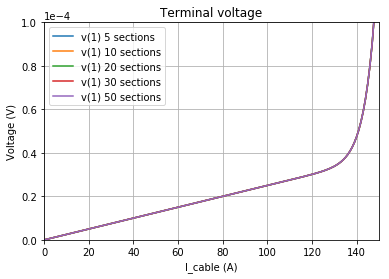

In [60]:
%matplotlib inline 

nsections = np.array([5,10,20,30,50])

for i in range(len(nsections)):
    ns = nsections[i] # Number of sections
    filename = f'{ns} sections.cir'
    Ic = np.zeros((ntape,ns))

    Ic[0,:] = 100
    Ic[1,:] = 50
    #print (Ic)
    Rc = np.zeros(ns+1)+1E-12
    #print(Rc)

    Labels,data_points = generatingnetlist(filename,ns,Ic,Rc)
    data = readdata(filename,Labels,data_points)

    plt.plot(data[:,1],data[:,2],label = Labels[2]+f' {ns} sections')

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('I_cable (A)')
plt.ylabel('Voltage (V)')
plt.title('Terminal voltage')
plt.ylim(0,100E-6)
plt.xlim(0,150)
plt.grid()
plt.legend()



### Conclusions
- In terms of the terminal voltage there is no difference in considering one or more sections for each tape. 

# Tape divided in n sections with different values for Ic along the tape

Assuptions:
- Considering 2 tapes
- Random distribution for Ic with standard deviation of 10% (mean value for tape 1 is 100 A and 50 A for tape 2).
- Contact resistance Rc is constant = 1E-12 Ohms

2.501475421279933e-07 131.77097472948105 30.42109824979613
Fit: Rt = 2.501475421279933e-07, Ic = 131.77097472948105, n = 30.42109824979613, Fit-error = 7.880760824149794e-07


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


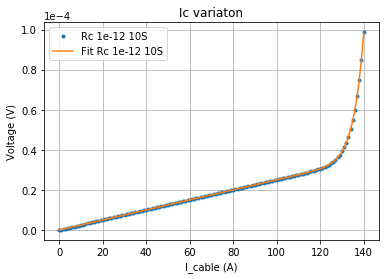

In [97]:
%matplotlib inline 

nsections = np.array([10])
sigma = np.array([10])

for i in range(len(nsections)):
    ns = nsections[i] # Number of sections
    filename = f'{ns} sections.cir'
    Ic = np.zeros((ntape,ns))
    mu1 = 100
    mu2 = 50
    Ic[0,:] = np.random.normal(mu1, mu1/10, ns)
    Ic[1,:] = np.random.normal(mu2, mu2/10, ns)
    #print (Ic)
    Rc = np.zeros(ns+1)+1E-12
    #print(Rc)

    Labels,data_points = generatingnetlist(filename,ns,Ic,Rc)
    data = readdata(filename,Labels,data_points)

'''
    plt.plot(data[:,1],data[:,2],label = Labels[2]+f' {ns} sections')

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('I_cable (A)')
plt.ylabel('Voltage (V)')
plt.title('Terminal voltage')
plt.ylim(0,100E-6)
plt.xlim(0,150)
plt.grid()
plt.legend()
'''

Vt1 = data[:,2]
Icable1 = data[:,1]
#plt.plot(Icable1,label = 'V terminal')

Vt_lim = []
Icable_lim = []
# Voltage limit
for l in range(len(Vt1)):
    if Vt1[l] <= 100e-6: # Limit of the total voltage
        Vt_lim.append(Vt1[l])
        Icable_lim.append(Icable1[l])

Vt_lim = np.array(Vt_lim)
Icable_lim = np.array(Icable_lim)
    
# Exponential fitting
Rt0,Ic0,n0 = 0.5E-6,150,30 # Initial values to fit exponential part
Rt_e,Ic_e,n_e = fit_exp(Icable_lim,Vt_lim,Rt0,Ic0,n0)
print(Rt_e,Ic_e,n_e)
    
# Getting curve from fitting 
Vt_fit_exp = model_func(Icable_lim,Rt_e,Ic_e,n_e)

# Calculating fitting error
Error = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))
    
# Plotting
print(f'Fit: Rt = {Rt_e}, Ic = {Ic_e}, n = {n_e}, Fit-error = {Error}')
plt.plot(Icable_lim,Vt_lim,'.',label = f'Rc {Rc[0]} {ns}S')
plt.plot(Icable_lim,Vt_fit_exp,label = f'Fit Rc {Rc[0]} {ns}S')

plt.title('Ic variaton')
plt.xlabel('I_cable (A)')
plt.ylabel('Voltage (V)')

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend()
plt.grid()

# Tape divided in n sections with different values for Rc

Assuptions:
- Considering 2 tapes
- Uniform Ic per tape (Ic1 = 100 A and Ic2 = 50)
- Contact resistance Rc is varying with mean value 1E-12 Ohms and standard deviation of 10%.

2.4999921447125514e-07 139.00988245009262 30.035572318533706
Fit: Rt = 2.4999921447125514e-07, Ic = 139.00988245009262, n = 30.035572318533706, Fit-error = 1.484484689210442e-09


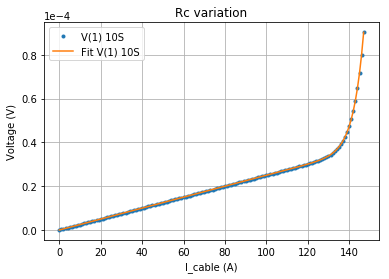

In [98]:
%matplotlib inline 

nsections = np.array([10])

for i in range(len(nsections)):
    ns = nsections[i] # Number of sections
    filename = f'{ns} sections.cir'
    Ic = np.zeros((ntape,ns))
    Ic[0,:] = 100
    Ic[1,:] = 50
    #print (Ic)
    mu = 1E-12
    Rc = np.random.normal(mu, mu/10, ns+1)
    #print(Rc)

    Labels,data_points = generatingnetlist(filename,ns,Ic,Rc)
    data = readdata(filename,Labels,data_points)

'''
    plt.plot(data[:,1],data[:,2],label = Labels[2]+f' {ns} sections')

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('I_cable (A)')
plt.ylabel('Voltage (V)')
plt.title('Terminal voltage')
plt.ylim(0,100E-6)
plt.xlim(0,150)
plt.grid()
plt.legend()
'''

Vt1 = data[:,2]
Icable1 = data[:,1]
#plt.plot(Icable1,label = 'V terminal')

Vt_lim = []
Icable_lim = []
# Voltage limit
for l in range(len(Vt1)):
    if Vt1[l] <= 100e-6: # Limit of the total voltage
        Vt_lim.append(Vt1[l])
        Icable_lim.append(Icable1[l])

Vt_lim = np.array(Vt_lim)
Icable_lim = np.array(Icable_lim)
    
# Exponential fitting
Rt0,Ic0,n0 = 0.5E-6,150,30 # Initial values to fit exponential part
Rt_e,Ic_e,n_e = fit_exp(Icable_lim,Vt_lim,Rt0,Ic0,n0)
print(Rt_e,Ic_e,n_e)
    
# Getting curve from fitting 
Vt_fit_exp = model_func(Icable_lim,Rt_e,Ic_e,n_e)

# Calculating fitting error
Error = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))
    
# Plotting
print(f'Fit: Rt = {Rt_e}, Ic = {Ic_e}, n = {n_e}, Fit-error = {Error}')
plt.plot(Icable_lim,Vt_lim,'.',label = f'V(1) {ns}S')
plt.plot(Icable_lim,Vt_fit_exp,label = f'Fit V(1) {ns}S')

plt.xlabel('I_cable (A)')
plt.ylabel('Voltage (V)')
plt.title('Rc variation')

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend()
plt.grid()

# Introducing a defect in 3-sections model

Assumptions:
- Tape 1: uniform Ic in three sections equals to 100 A.
- Tape 2: uniform Ic in 1st and 3rd sections (100 A) and lower Ic for 2nd section (50 A).
- Contact resistance: short (10 nOhm) and open case (1000 Ohm).
- Uniform terminal resistance.

[[100. 100. 100.]
 [100.  50. 100.]]
Rc 1e-08: Rt = 2.503e-07, Ic = 155.6726, n = 29.9669, Fit-error = 1.868e-07

[[100. 100. 100.]
 [100.  50. 100.]]
Rc 1000.0: Rt = 2.727e-07, Ic = 153.341, n = 22.259, Fit-error = 1.85074e-05



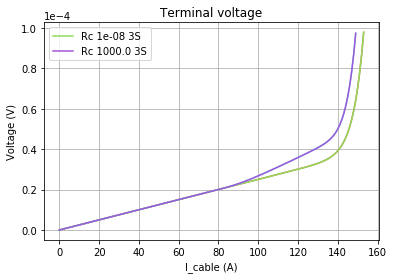

In [23]:
%matplotlib inline 

R_cvals = np.array([10E-9,1000])
ntape = 2
for i in range(len(R_cvals)):
    ns = 3 # Number of sections
    filename = f'{ns} sections - Rc {R_cvals[i]}.cir'
    Ic = np.zeros((ntape,ns))

    Ic[0,:] = 100
    Ic[1,:] = 100
    Ic[1,1] = 50
    print (Ic)
    Rc = np.zeros(ns+1)+R_cvals[i]
    #print(Rc)

    Labels,data_points = generatingnetlist(filename,ns,Ic,Rc)
    data = readdata(filename,Labels,data_points)
    
    Icable = data[:,1]
    Vt = data[:,2]
    #plt.plot(Icable,Vt,label = f'Rc {Rc[i]}')
    
    Vt_lim = []
    Icable_lim = []
    # Voltage limit
    for l in range(len(Vt)):
        if Vt[l] <= 100e-6: # Limit of the total voltage
            Vt_lim.append(Vt[l])
            Icable_lim.append(Icable[l])
    
    Vt_lim = np.array(Vt_lim)
    Icable_lim = np.array(Icable_lim)
    
    plt.plot(Icable_lim,Vt_lim)
    # Exponential fitting
    Rt0,Ic0,n0 = 0.5E-6,100,30 # Initial values to fit exponential part
    Rt_e,Ic_e,n_e = fit_exp(Icable_lim,Vt_lim,Rt0,Ic0,n0)
    #print(Rt_e,Ic_e,n_e)

    # Getting curve from fitting 
    Vt_fit_exp = model_func(Icable_lim,Rt_e,Ic_e,n_e)

    # Calculating fitting error
    Error = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))

    # Plotting
    print(f'Rc {Rc[i]}: Rt = {round(Rt_e,10)}, Ic = {round(Ic_e,4)}, n = {round(n_e,4)}, Fit-error = {round(Error,10)}\n')
    plt.plot(Icable_lim,Vt_lim,label = f'Rc {Rc[i]} 3S')
    #plt.plot(Icable_lim,Vt_fit_exp,label = f'Fit Rc {Rc[i]} 3S')
    #plt.plot(data[:,1],data[:,2],label = Labels[2]+f'{ns} sections- Rc {R_cvals[i]}')

    
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('I_cable (A)')
plt.ylabel('Voltage (V)')
plt.title('Terminal voltage')
#plt.ylim(0,100E-6)
#plt.xlim(0,200)
plt.grid()
plt.legend()

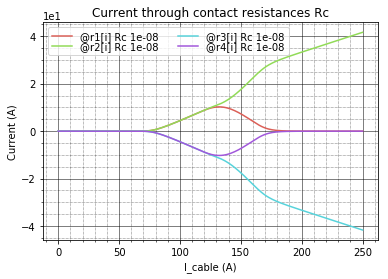

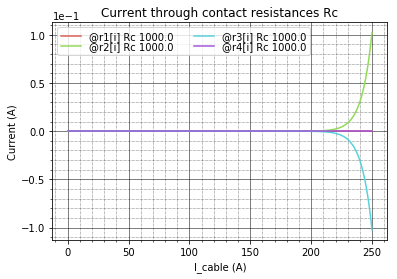

In [24]:
# Testing different values of contact resistance
sns.set_palette(sns.color_palette("hls", 4))
# Generating netlists and saving data

for i in range(len(R_cvals)):
    ns = 3 # Number of sections
    filename = f'{ns} sections - Rc {R_cvals[i]}.cir'
    #generatenetlist(filename,Rc[i])
    data = readdata(filename,Labels,data_points)
    nc = 11
    fig, ax = plt.subplots()
    for j in range(ns+1):
        ax.plot(data[:,1],data[:,j+nc],label = Labels[j+nc]+f' Rc {R_cvals[i]}')
    plt.xlabel('I_cable (A)')
    plt.ylabel('Current (A)')
    plt.title('Current through contact resistances Rc')
    #plt.xlim(0,200)
    ax.minorticks_on()
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
# Customize the minor grid
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    
    ax.tick_params(which='both') # turn off bottom ticks
    
    plt.legend(labelspacing=0.001,ncol=2,loc='best')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.show()
    

[[100. 100. 100.]
 [100. 100. 100.]]
Rc 1e-08: Rt = 2.5e-07, Ic = 200.066, n = 30.0211, Fit-error = 9e-10

[[100. 100. 100.]
 [100. 100. 100.]]
Rc 1000.0: Rt = 2.5e-07, Ic = 200.066, n = 30.0211, Fit-error = 9e-10



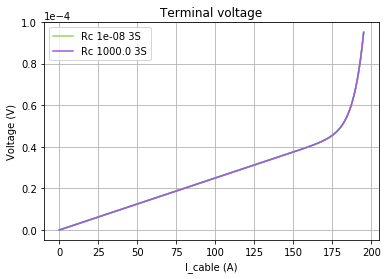

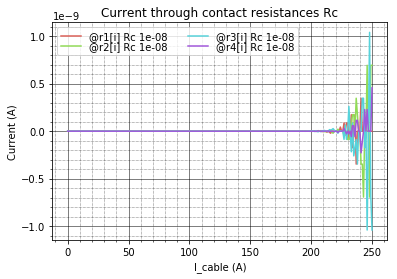

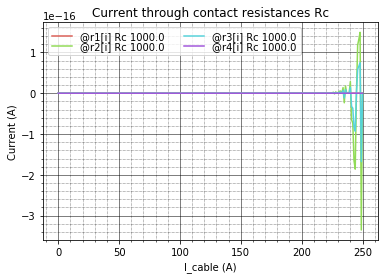

In [25]:
%matplotlib inline 

R_cvals = np.array([10E-9,1000])
ntape = 2
for i in range(len(R_cvals)):
    ns = 3 # Number of sections
    filename = f'{ns} sections - Rc {R_cvals[i]} identical.cir'
    Ic = np.zeros((ntape,ns))

    Ic[0,:] = 100
    Ic[1,:] = 100
    print (Ic)
    Rc = np.zeros(ns+1)+R_cvals[i]
    #print(Rc)

    Labels,data_points = generatingnetlist(filename,ns,Ic,Rc)
    data = readdata(filename,Labels,data_points)
    
    Icable = data[:,1]
    Vt = data[:,2]
    #plt.plot(Icable,Vt,label = f'Rc {Rc[i]}')
    
    Vt_lim = []
    Icable_lim = []
    # Voltage limit
    for l in range(len(Vt)):
        if Vt[l] <= 100e-6: # Limit of the total voltage
            Vt_lim.append(Vt[l])
            Icable_lim.append(Icable[l])
    
    Vt_lim = np.array(Vt_lim)
    Icable_lim = np.array(Icable_lim)
    
    plt.plot(Icable_lim,Vt_lim)
    # Exponential fitting
    Rt0,Ic0,n0 = 0.5E-6,100,30 # Initial values to fit exponential part
    Rt_e,Ic_e,n_e = fit_exp(Icable_lim,Vt_lim,Rt0,Ic0,n0)
    #print(Rt_e,Ic_e,n_e)

    # Getting curve from fitting 
    Vt_fit_exp = model_func(Icable_lim,Rt_e,Ic_e,n_e)

    # Calculating fitting error
    Error = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))

    # Plotting
    print(f'Rc {Rc[i]}: Rt = {round(Rt_e,10)}, Ic = {round(Ic_e,4)}, n = {round(n_e,4)}, Fit-error = {round(Error,10)}\n')
    plt.plot(Icable_lim,Vt_lim,label = f'Rc {Rc[i]} 3S')
    #plt.plot(Icable_lim,Vt_fit_exp,label = f'Fit Rc {Rc[i]} 3S')
    #plt.plot(data[:,1],data[:,2],label = Labels[2]+f'{ns} sections- Rc {R_cvals[i]}')

    
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('I_cable (A)')
plt.ylabel('Voltage (V)')
plt.title('Terminal voltage')
#plt.ylim(0,100E-6)
#plt.xlim(0,200)
plt.grid()
plt.legend()
plt.show()

# Testing different values of contact resistance
sns.set_palette(sns.color_palette("hls", 4))
# Generating netlists and saving data

for i in range(len(R_cvals)):
    ns = 3 # Number of sections
    filename = f'{ns} sections - Rc {R_cvals[i]} identical.cir'
    #generatenetlist(filename,Rc[i])
    data = readdata(filename,Labels,data_points)
    nc = 11
    fig, ax = plt.subplots()
    for j in range(ns+1):
        ax.plot(data[:,1],data[:,j+nc],label = Labels[j+nc]+f' Rc {R_cvals[i]}')
    plt.xlabel('I_cable (A)')
    plt.ylabel('Current (A)')
    plt.title('Current through contact resistances Rc')
    #plt.xlim(0,200)
    ax.minorticks_on()
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
# Customize the minor grid
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    
    ax.tick_params(which='both') # turn off bottom ticks
    
    plt.legend(labelspacing=0.001,ncol=2,loc='best')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.show()
    